# When Tesseract Brings Friends: Layout Analysis, Language Identification, and Super-Resolution for the Optical Character Recognition of Medieval Texts

In this Jupyter notebook, we will produce the results for the *When Tesseract Brings Friends: Layout Analysis, Language Identification, and Super-Resolution for the Optical Character Recognition of Medieval Texts* published in the proceedings of [RASLAN 2021][1].

 [1]: https://raslan2021.nlp-consulting.net/

## Preliminaries

In this section, we will set up some preliminary code.

First, we will disable autocompletion in Jedi, since it [can cause issues][1].

 [1]: https://stackoverflow.com/q/65843310/657401

In [1]:
%config Completer.use_jedi = False

Next, we will define some notable points in our Git history from which we will extract results.   
We will also define some helper functions for reading files at specific points in the Git history.

In [2]:
from typing import Dict, Optional

GIT_COMMITS: Dict[Optional[str], Optional[str]] = {
    None: '3lang',  # default commit
    '3lang + cg': '3lang',
    '3lang + ml': '43c912a615b721dc61aca21ae23727c20d4d8d14',  # branch master, before we've switched to CG layout analysis
    '3lang': 'e8ca691e6772745b453679b48e46e4102c8a0502',  # current branch master
    '3lang + nlda': '3lang',
    '3lang + olda': '60b7449dce0afd63bae9ac817932cc889a3d519c^',
    '9lang': '005c77b2dd26625c3f112f0449d158f2dd5800e9',  # current branch manylang
    '9lang + nlda': 'c91ba8c8200291feb978e0db014a33321add16b0^',
    '9lang + olda': '9lang',
}

In [3]:
from io import StringIO

def git_open(filename: str, commit: Optional[str] = None) -> StringIO:
    from git import Repo
    repo = Repo(path='..')
    while commit in GIT_COMMITS:
        commit = GIT_COMMITS[commit]
    file_contents = repo.git.show(f'{commit}:{filename}')
    return StringIO(file_contents)

Next, we will import some basic libraries.

In [4]:
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn

In [5]:
plt.rcParams["figure.figsize"] = [4.821160277777778, 3.25]

Finally, we will set where figures should be stored.

In [6]:
basename = 'when-tesseract-brings-friends'

In [7]:
from pathlib import Path

Path(basename).mkdir(exist_ok=True)

## Optical Character Recognition

In this section, we will investigate the impact of three  reprocessing techniques on the accuracy of Tesseract 4.

### Preliminaries

In this section, we will set up some preliminary code.

First, we will set up a function to read OCR accuracy results.

In [8]:
from math import isnan
from typing import List

def read_ocr_accuracy_result(ocr_name: str,
                             git_commit: Optional[str] = None,
                             ground_truth: str = 'human',
                             columns: Optional[bool] = None) -> Dict[str, List[float]]:
    result = {'cer': 3 * [None], 'wer': 3 * [None]}
    columns_string = '' if columns is None else ('-with-columns' if columns else '-without-columns')
    filename = f'output-{ocr_name}.accuracy-results-{ground_truth}{columns_string}'
    with git_open(filename, git_commit) as f:
        for line in f:
            key = None

            if 'CER' in line:
                key = 'cer'
            elif 'WER' in line:
                key = 'wer'
            else:
                continue
            
            if 'point estimate' in line:
                match = re.search(r'([0-9]+\.[0-9]+|nan)%', line)
                matched_point = float(match.group(1))
                result[key][1] = matched_point if matched_point is not isnan(matched_point) else 0.0
            elif 'CI estimate' in line:
                match = re.search(r'\[([0-9]+\.[0-9]+|nan)%; *([0-9]+\.[0-9]+|nan)%\]', line)
                matched_bottom_limit, matched_top_limit = float(match.group(1)), float(match.group(2))
                result[key][0] = matched_bottom_limit if matched_bottom_limit is not isnan(matched_bottom_limit) else 0.0
                result[key][2] = matched_top_limit if matched_top_limit is not isnan(matched_top_limit) else 0.0
      
    for values in result.values():
        assert None not in values
    
    return result

### Layout Analysis

In this section, we will evaluate the impact of layout analysis on the accuracy of Tesseract 4.

#### Preliminaries
First, we will set up a function to read OCR accuracy results.

In [9]:
from typing import List

def read_classification_accuracy_result(algorithm: str,
                                        ocr_name: str = 'ocr4',
                                        git_commit: Optional[str] = None) -> Dict[str, List[float]]:
    result = {'tp': None, 'tn': None, 'fp': None, 'fn': None}
    filename = f'output-{ocr_name}.multicolumn-detection-results-{algorithm}.md'
    pattern = r'\(([0-9]+) /'
    with git_open(filename, git_commit) as f:
        for line in f:
            if '# True positives' in line:
                match = re.search(pattern, line)
                result['tp'] = int(match.group(1))
            elif '# True negatives' in line:
                match = re.search(pattern, line)
                result['tn'] = int(match.group(1))
            elif '# False positives' in line:
                match = re.search(pattern, line)
                result['fp'] = int(match.group(1))
            elif '# False negatives' in line:
                match = re.search(pattern, line)
                result['fn'] = int(match.group(1))

    assert None not in result.values()
    return result

#### Classification Accuracy

In this section, we will show the intrinsic classification accuracy of layout analysis.

In [10]:
labels_algorithms = [
    ('CG', 'cg'),
    ('ML', 'ml'),
]

In [11]:
ylabels = ['Predicted single', 'Predicted multi']
xlabels = ['Actually single', 'Actually multi']

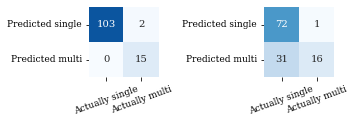

In [12]:
fig, axes = plt.subplots(ncols=2)
for (_, algorithm), ax in zip(labels_algorithms, axes):
    result = read_classification_accuracy_result(algorithm)
    cm = [[result['tn'], result['fn']], [result['fp'], result['tp']]]
    df_cm = pd.DataFrame(cm, ylabels, xlabels)
    sn.heatmap(df_cm, annot=True, vmin=0, vmax=120, square=True, fmt='g', ax=ax, cbar=False, cmap='Blues')
    ax.set_xticklabels(xlabels, rotation=20)
plt.savefig(f'{basename}/classification-accuracy-layout-analysis.pdf')
plt.show()

#### OCR Accuracy
Second, we will show the extrinsic OCR accuracies with and without layout analysis.

In [13]:
xlabels_names_commits = [
    ('Google Vision AI', 'ocr-google-lowres', None),
    ('Google + Tess. 4 (CG)', 'ocr-ocr4-google-lowres', '3lang + cg'),
    ('Google + Tess. 4 (ML)', 'ocr-ocr4-google-lowres', '3lang + ml'),
    ('Tesseract 4', 'ocr4', None),
]

In [14]:
xlabels_emph = (False, True, False, False)

In [15]:
llabels_keys_columns = [
    ('Pages without columns', 'wer', False),
    ('All pages', 'wer', None),
    ('Pages with columns', 'wer', True),
]

In [16]:
offsets = (-0.15, 0, 0.15)

In [17]:
formats = ('x', 'o', '+')

In [18]:
from itertools import chain

major_yticks = (3, 5, 10, 20, 50, 80, 100)
minor_yticks = list(chain(range(3, 20), range(20, 100, 10)))

In [19]:
xmargins = 0.2

In [20]:
ylims = (3, 100)

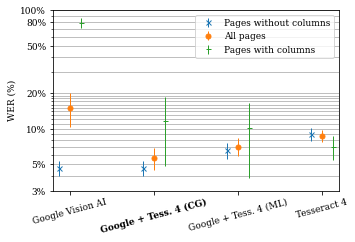

In [21]:
from matplotlib.transforms import ScaledTranslation

fig, ax = plt.subplots()
x = range(len(xlabels_names_commits))
translations = [ax.transData + ScaledTranslation(offset, 0, fig.dpi_scale_trans) for offset in offsets]

for (llabel, key, columns), translation, fmt in zip(llabels_keys_columns, translations, formats):
    y, yerr = [], []
    for _, ocr_name, git_commit in xlabels_names_commits:
        result = read_ocr_accuracy_result(ocr_name, git_commit, columns=columns)
        point_estimate = result[key][1]
        ci_estimate_size = (result[key][2] - result[key][0]) / 2.0
        y.append(point_estimate)
        yerr.append(ci_estimate_size)
    plt.errorbar(x, y, yerr=yerr, fmt=fmt, transform=translation, label=llabel)

xlabels = [xlabel for xlabel, _, _ in xlabels_names_commits]
plt.xticks(x, xlabels, rotation=15)
plt.yscale('log')
minor_yticks_list = [y for y in minor_yticks if y not in major_yticks]
plt.yticks(major_yticks, [f'{ytick:g}%' for ytick in major_yticks])
ax.set_yticks(minor_yticks_list, minor=True)
ax.set_yticklabels([''] * len(minor_yticks_list), minor=True)
plt.xlim(-xmargins, len(x) - 1 + xmargins)
plt.ylim(ylims)
plt.legend(loc='best')
plt.grid(which='both', axis='y')

for xlabel, is_bold in zip(ax.get_xticklabels(), xlabels_emph):
    if is_bold:
        xlabel.set_fontweight('bold')

plt.ylabel('WER (%)')
plt.savefig(f'{basename}/ocr-accuracy-layout-analysis.pdf')
plt.show()

### Language Identification

In this section, we will evaluate the impact of language identification on the accuracy of Tesseract 4.

In [22]:
llabels_names_commits = [
    ('Three languages, para. LI', ('ocr4', 'ocr4-twopass.{:02d}'), '3lang + olda'),
    ('Three languages, word LI', ('ocr4', 'ocr4-twopass.{:02d}'), '3lang + nlda'),
    ('Nine languages, para. LI', ('ocr4-onepass', 'ocr4-twopass.{:02d}'), '9lang + olda'),
    ('Nine languages, word LI', ('ocr4-onepass', 'ocr4-twopass.{:02d}'), '9lang + nlda'),
]

In [23]:
thresholds = (0, 25, 50, 75, 100)

In [24]:
xlabels = ['One-pass'] + [f'Two-pass ({threshold}%)' for threshold in thresholds]

In [25]:
xlabels_emph = (False, True, False, False, False, False)

In [26]:
offsets = (-0.15, -0.05, 0.05, 0.15)

In [27]:
formats = ('x', 'o', '+', 's')

In [28]:
from itertools import chain

major_yticks = (7, 10, 20, 50, 100)
minor_yticks = list(chain(range(7, 20), range(20, 100, 10)))

In [29]:
xmargins = 0.4

In [30]:
ylims = (7, 100)

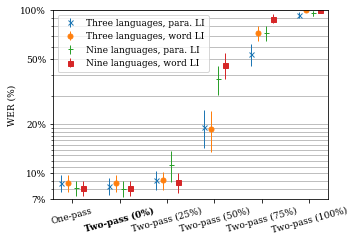

In [31]:
from matplotlib.transforms import ScaledTranslation

fig, ax = plt.subplots()
x = range(len(thresholds) + 1)
translations = [ax.transData + ScaledTranslation(offset, 0, fig.dpi_scale_trans) for offset in offsets]

for (llabel, ocr_names, git_commit), translation, fmt in zip(llabels_names_commits, translations, formats):
    y, yerr = [], []
    onepass_ocr_name, twopass_ocr_name_template = ocr_names

    onepass_result = read_ocr_accuracy_result(onepass_ocr_name, git_commit)
    onepass_point_estimate = onepass_result['wer'][1]
    onepass_ci_estimate_size = (onepass_result['wer'][2] - onepass_result['wer'][0]) / 2.0
    y.append(onepass_point_estimate)
    yerr.append(onepass_ci_estimate_size)

    for threshold in thresholds:
        twopass_ocr_name = twopass_ocr_name_template.format(threshold)
        twopass_result = read_ocr_accuracy_result(twopass_ocr_name, git_commit)
        twopass_point_estimate = twopass_result['wer'][1]
        twopass_ci_estimate_size = (twopass_result['wer'][2] - twopass_result['wer'][0]) / 2.0
        y.append(twopass_point_estimate)
        yerr.append(twopass_ci_estimate_size)

    plt.errorbar(x, y, yerr=yerr, fmt=fmt, transform=translation, label=llabel)

plt.xticks(x, xlabels, rotation=15)
plt.yscale('log')
minor_yticks_list = [y for y in minor_yticks if y not in major_yticks]
plt.yticks(major_yticks, [f'{ytick:g}%' for ytick in major_yticks])
ax.set_yticks(minor_yticks_list, minor=True)
ax.set_yticklabels([''] * len(minor_yticks_list), minor=True)
plt.xlim(-xmargins, len(x) - 1 + xmargins)
plt.ylim(ylims)
plt.legend(loc='best')
plt.grid(which='both', axis='y')

for xlabel, is_bold in zip(ax.get_xticklabels(), xlabels_emph):
    if is_bold:
        xlabel.set_fontweight('bold')

plt.ylabel('WER (%)')
plt.savefig(f'{basename}/ocr-accuracy-language-identification.pdf')
plt.show()

### Super-Resolution

In this section, we will evaluate the impact of image super-resolution on the accuracy of Tesseract 4.

In [32]:
xlabels_names = [
    ('Low-res.', ('downscaled-ocr4', 'ocr-google-lowres')),
    ('Bilinear', ('downscaled-bilinear-ocr4', 'downscaled-bilinear-google')),
    ('Potrace', ('downscaled-potrace-ocr4', 'downscaled-potrace-google')),
    ('Waifu2x (noise0)', ('downscaled-waifu2x-low-noise-ocr4', 'downscaled-waifu2x-low-noise-google')),
    ('Waifu2x (noise3)', ('downscaled-waifu2x-high-noise-ocr4', 'downscaled-waifu2x-high-noise-google')),
    ('SRGAN (scanned)', ('downscaled-srgan-ocr4', 'downscaled-srgan-google')),
    ('SRGAN (CDB VI)', ('downscaled-srgan_cdbt6-ocr4', 'downscaled-srgan_cdbt6-google')),
    ('High-res.', ('ocr4', 'ocr-google-hires')),
]

In [33]:
xlabels_emph = (False, False, False, False, True, False, False, False)

In [34]:
offsets = (-0.05, 0.05)

In [35]:
llabels = ['Tesseract 4', 'Google Vision AI']

In [36]:
formats = ('o', 'x')

In [37]:
from itertools import chain

major_yticks = (6, 10, 20, 30)
minor_yticks = chain(range(6, 20), range(20, 30, 5))

In [38]:
xmargins = 0.3

In [39]:
ylims = (6, 30)

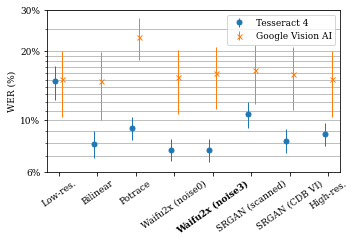

In [40]:
from matplotlib.transforms import ScaledTranslation

fig, ax = plt.subplots()
x = range(len(xlabels_names))
translations = [ax.transData + ScaledTranslation(offset, 0, fig.dpi_scale_trans) for offset in offsets]

for (ocr_name_index, llabel), translation, fmt in zip(enumerate(llabels), translations, formats):
    y, yerr = [], []
    for _, ocr_names in xlabels_names:
        ocr_name = ocr_names[ocr_name_index]
        result = read_ocr_accuracy_result(ocr_name)
        point_estimate = result['wer'][1]
        ci_estimate_size = (result['wer'][2] - result[key][0]) / 2.0
        y.append(point_estimate)
        yerr.append(ci_estimate_size)
    plt.errorbar(x, y, yerr=yerr, fmt=fmt, transform=translation, label=llabel)

xlabels = [xlabel for xlabel, _ in xlabels_names]
plt.xticks(x, xlabels, rotation=35)
plt.yscale('log')
minor_yticks_list = [y for y in minor_yticks if y not in major_yticks]
plt.yticks(major_yticks, [f'{ytick:g}%' for ytick in major_yticks])
ax.set_yticks(minor_yticks_list, minor=True)
ax.set_yticklabels([''] * len(minor_yticks_list), minor=True)
plt.xlim(-xmargins, len(x) - 1 + xmargins)
plt.ylim(ylims)
plt.legend(loc='best')
plt.grid(which='both', axis='y')

for xlabel, is_bold in zip(ax.get_xticklabels(), xlabels_emph):
    if is_bold:
        xlabel.set_fontweight('bold')

plt.ylabel('WER (%)')
plt.savefig(f'{basename}/ocr-accuracy-super-resolution.pdf')
plt.show()

### Best Configurations

In this section, we will show the most accurate combination of preprocessing techniques.

In [41]:
result = read_ocr_accuracy_result('downscaled-waifu2x-high-noise-ocr4-twopass-google-lowres.00', '9lang + olda')
print(f'WER: {result["wer"][1]:g}% [{result["wer"][0]:g}%; {result["wer"][2]:g}%]')

WER: 5.42% [4.46%; 6.37%]


## Language Identification

In this section, we will compare Tesseract 4 with three other OCR algorithms on the language identification task.

### Preliminaries

In this section, we will set up some preliminary code.

First, we will set up a function to read language detection results.

In [42]:
from typing import List

def read_language_detection_results(ocr_name: str,
                                    git_commit: Optional[str] = None,
                                    ground_truth: str = 'human',
                                    language_detection_algorithm: str = 'olda') -> Dict[str, List[float]]:
    result = {'iou': 3 * [None], 'spearman': 3 * [None], 'accuracy@1': 3 * [None]}
    filename = f'output-{ocr_name}.language-detection-page-results-{ground_truth}-{language_detection_algorithm}'
    with git_open(filename, git_commit) as f:
        for line in f:
            key = None

            if 'IOU' in line:
                key = 'iou'
            elif 'Spearman' in line:
                key = 'spearman'
            elif 'Accuracy@1' in line:
                key = 'accuracy@1'
            else:
                continue
            
            if 'point estimate' in line:
                match = re.search(r'(-?[0-9]+\.[0-9]+|nan)%?', line)
                matched_point = float(match.group(1))
                result[key][1] = matched_point if matched_point is not isnan(matched_point) else 0.0
            elif 'CI estimate' in line:
                match = re.search(r'\[(-?[0-9]+\.[0-9]+|nan)%?; *(-?[0-9]+\.[0-9]+|nan)%?\]', line)
                matched_bottom_limit, matched_top_limit = float(match.group(1)), float(match.group(2))
                result[key][0] = matched_bottom_limit if matched_bottom_limit is not isnan(matched_bottom_limit) else 0.0
                result[key][2] = matched_top_limit if matched_top_limit is not isnan(matched_top_limit) else 0.0
      
    for values in result.values():
        assert None not in values
    
    return result

### Language Identification

In this section, we will compare Tesseract 4 with three other OCR algorithms on the language identification task.

In [43]:
xlabels = ('Google Vision AI', 'Tesseract 3', 'Tesseract 4', 'Tesseract 3 + 4')

In [44]:
xlabels_emph = (True, False, False, False)

In [45]:
extra_llabel, extra_name, extra_commit, extra_algorithm = 'Many languages, proprietary LI', 'ocr-google-lowres', '3lang', 'olda'

In [46]:
llabels_names_commits_algorithms = [
    ('Three languages, paragraph LI', ('ocr3', 'ocr4', 'ocr3+4'), '3lang', 'olda'),
    ('Three languages, word LI', ('ocr3', 'ocr4', 'ocr3+4'), '3lang', 'nlda'),
    ('Nine languages, paragraph LI', ('ocr3', 'ocr4-onepass', 'ocr3+4'), '9lang', 'olda'),
    ('Nine languages, word LI', ('ocr3', 'ocr4-onepass', 'ocr3+4'), '9lang', 'nlda'),
]

In [47]:
offsets = (-0.25, -0.25 + 1 / 6, 0.25 - 1 / 6, 0.25)

In [48]:
formats = ('x', 'o', '+', 's', 'v')

In [49]:
from itertools import chain

major_yticks = (0, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100)
minor_yticks = list(chain(range(0, 95, 5), range(95, 100)))

In [50]:
xmargins = 0.3

In [51]:
ylims = (0, 100)

In [52]:
gamma = 1.5

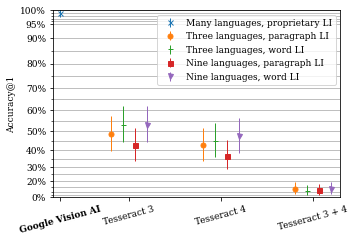

In [53]:
from matplotlib.transforms import ScaledTranslation

fig, ax = plt.subplots()
x = [offsets[-1]] + list(range(1, len(xlabels)))
translations = [ax.transData + ScaledTranslation(offset, 0, fig.dpi_scale_trans) for offset in offsets]

extra_result = read_language_detection_results(extra_name, extra_commit, language_detection_algorithm=extra_algorithm)
extra_point_estimate = extra_result['accuracy@1'][1]
extra_ci_estimate_size = (extra_result['accuracy@1'][2] - extra_result['accuracy@1'][0]) / 2.0
plt.errorbar(x[0], [extra_point_estimate], yerr=[extra_ci_estimate_size], fmt=formats[0], label=extra_llabel)

for (llabel, ocr_names, git_commit, language_detection_algorithm), translation, fmt \
        in zip(llabels_names_commits_algorithms, translations, formats[1:]):
    y, yerr = [], []
    for ocr_name in ocr_names:
        result = read_language_detection_results(ocr_name, git_commit, language_detection_algorithm=language_detection_algorithm)
        point_estimate = result['accuracy@1'][1]
        ci_estimate_size = (result['accuracy@1'][2] - result['accuracy@1'][0]) / 2.0
        y.append(point_estimate)
        yerr.append(ci_estimate_size)
    plt.errorbar(x[1:], y, yerr=yerr, fmt=fmt, transform=translation, label=llabel)

plt.xticks(x, xlabels, rotation=15)
plt.yscale('function', functions=(lambda x: np.sign(x) * np.abs(x)**gamma, lambda x: np.sign(x) * np.abs(x)**(1.0 / gamma)))
minor_yticks_list = [y for y in minor_yticks if y not in major_yticks]
plt.yticks(major_yticks, [f'{ytick:g}%' for ytick in major_yticks])
ax.set_yticks(minor_yticks_list, minor=True)
ax.set_yticklabels([''] * len(minor_yticks_list), minor=True)
plt.xlim(x[0] - xmargins + 0.9 * offsets[-1], len(x) - 1 + xmargins)
plt.ylim(ylims[0], ylims[1])
plt.legend(loc='best')
plt.grid(which='both', axis='y')

for xlabel, is_bold in zip(ax.get_xticklabels(), xlabels_emph):
    if is_bold:
        xlabel.set_fontweight('bold')

plt.ylabel(r"Accuracy@1")
plt.savefig(f'{basename}/language-identification.pdf')
plt.show()